## e008 EDA
 * oof analysis
 * meta features (mainly use 3 phase diff)


In [1]:
import pandas as pd
import numpy as np
import gc
import pickle
import pyarrow.parquet as pq
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

import scipy
from scipy import signal
from scipy.signal import butter

from matplotlib import pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../guchio_utils/')

In [2]:
#plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# %config InlineBackend.figure_formats = {'png', 'retina'}
%load_ext autoreload
%autoreload 1

### OOF analysis

In [3]:
#trn_df = pd.read_parquet('../inputs/origin/train.parquet.zip', compression='zip')
trn_df = pq.read_pandas('../inputs/origin/train.parquet').to_pandas()
trn_meta_df = pd.read_csv('../inputs/origin/metadata_train.csv')

In [4]:
trn_hp_dn_df = pd.read_pickle('../inputs/prep/train_hp_dn.pkl.gz', compression='gzip')
trn_hp_dn_df.head()

0         1          2          3         4          5          6  \
0  13.601562  0.000906 -14.601562 -14.359375 -4.300781  17.921875  -8.484375   
1  16.234375  0.000906 -17.515625 -17.390625 -5.820312  21.062500  -9.898438   
2  11.335938  0.000906 -12.445312 -14.546875 -4.878906  18.562500 -11.429688   
3  12.453125  0.000906 -13.718750 -14.234375 -4.585938  18.843750 -12.609375   
4  17.343750  0.000906 -18.937500 -13.914062 -3.957031  19.437500 -13.406250   

           7         8          9    ...           8702       8703       8704  \
0   6.421875 -0.000802 -13.218750    ...      15.773438 -17.171875  10.335938   
1   9.070312 -0.000802 -15.539062    ...      18.187500 -21.968750  12.976562   
2  12.156250 -0.000802 -12.531250    ...      14.906250 -17.859375  11.609375   
3  14.265625 -0.000802 -11.726562    ...      14.937500 -18.078125  11.570312   
4  15.304688 -0.000802 -11.187500    ...      15.960938 -19.500000  11.343750   

       8705       8706      8707       8708       8709      8710       8711  
0  6.441406  11.609375  3.173828 -20.593750 -13.429688 -6.679688  17.515625  
1  7.500000  14.734375  4.218750 -18.437500 -16.000000 -7.945312  22.015625  
2  5.574219  13.398438  5.417969 -17.937500 -13.179688 -5.648438  20.375000  
3  6.031250  13.648438  6.257812 -16.890625 -13.085938 -6.136719  21.187500  
4  7.976562  13.796875  6.699219 -17.671875 -13.539062 -8.343750  21.234375  

[5 rows x 8712 columns]

In [15]:
with open('../oofs/e007_2019-01-16-14-16-42_0.5488_0.21_oofs.pkl', 'rb') as fin:
    oof = pickle.load(fin)

In [16]:
oof

[[array([  24,   25,   26, ..., 8709, 8710, 8711]),
  array([   0,    1,    2, ..., 8670, 8671, 8672]),
  array([  18,   19,   20, ..., 8706, 8707, 8708]),
  array([  27,   28,   29, ..., 8685, 8686, 8687]),
  array([   9,   10,   11, ..., 8706, 8707, 8708])],
 [array([0.00065297, 0.00485639, 0.00188172, ..., 0.42367861, 0.14324415,
         0.30101049]),
  array([7.49939629e-03, 1.65781616e-02, 9.61511092e-03, ...,
         1.13133974e-05, 4.21781195e-05, 4.90997010e-06]),
  array([2.75500418e-05, 2.23110163e-03, 7.92025700e-01, ...,
         1.44992869e-05, 4.92243258e-05, 1.66619846e-06]),
  array([1.33144961e-05, 6.49238018e-04, 1.00969385e-04, ...,
         5.60321817e-05, 1.06959219e-03, 2.20406883e-05]),
  array([3.78869330e-05, 3.88764728e-05, 3.22647510e-06, ...,
         1.78365670e-05, 1.61193180e-05, 2.11632210e-06])]]

In [25]:
val_idxes = []
y_preds = []
for val_idx, y_pred in zip(oof[0], oof[1]):
    val_idxes.append(val_idx)
    y_preds.append(y_pred)
oof_df = pd.DataFrame()    
oof_df['val_idx'] = np.concatenate(val_idxes)
oof_df['y_pred'] = np.concatenate(y_preds)
oof_df['target'] = trn_meta_df.set_index('signal_id').loc[oof_df.val_idx]
oof_df

ValueError: cannot reindex from a duplicate axis

In [31]:
# folding がおかしい...
oof_df.sort_values('val_idx').drop_duplicates('val_idx')

val_idx    y_pred
1743        0  0.007499
1744        1  0.016578
1745        2  0.009615
6972        9  0.000038
6973       10  0.000039
6974       11  0.000003
3486       18  0.000028
3487       19  0.002231
3488       20  0.792026
0          24  0.000653
1          25  0.004856
2          26  0.001882
5229       27  0.000013
5230       28  0.000649
5231       29  0.000101
5232       33  0.000009
5233       34  0.000021
5234       35  0.001678
6          36  0.009518
1750       37  0.029145
8          38  0.008576
6975       39  0.306239
6976       40  0.068054
6977       41  0.203877
3489       42  0.003195
5236       43  0.003642
5237       44  0.001124
1752       45  0.000003
1753       46  0.000073
1754       47  0.000001
...       ...       ...
8703     8652  0.000003
8704     8653  0.000002
8705     8654  0.000008
6966     8655  0.000141
6967     8656  0.000271
6968     8657  0.001832
1734     8667  0.000080
1735     8668  0.000115
1736     8669  0.000042
3483     8670  0.000011
3484     8671  0.000042
3485     8672  0.000005
8706     8676  0.000003
8707     8677  0.000004
5225     8678  0.000002
6969     8685  0.000056
6970     8686  0.001070
6971     8687  0.000022
8709     8688  0.000016
8710     8689  0.013853
8711     8690  0.002454
1737     8694  0.000352
1738     8695  0.000065
1739     8696  0.006360
5226     8706  0.000014
5227     8707  0.000049
5228     8708  0.000002
1740     8709  0.423679
1741     8710  0.143244
1742     8711  0.301010

[5793 rows x 2 columns]

In [26]:
trn_meta_df.set_index('signal_id')

id_measurement  phase  target
signal_id                               
0                       0      0       0
1                       0      1       0
2                       0      2       0
3                       1      0       1
4                       1      1       1
5                       1      2       1
6                       2      0       0
7                       2      1       0
8                       2      2       0
9                       3      0       0
10                      3      1       0
11                      3      2       0
12                      4      0       0
13                      4      1       0
14                      4      2       0
15                      5      0       0
16                      5      1       0
17                      5      2       0
18                      6      0       0
19                      6      1       0
20                      6      2       0
21                      7      0       0
22                      7      1       0
23                      7      2       0
24                      8      0       0
25                      8      1       0
26                      8      2       0
27                      9      0       0
28                      9      1       0
29                      9      2       0
...                   ...    ...     ...
8682                 2894      0       0
8683                 2894      1       0
8684                 2894      2       0
8685                 2895      0       0
8686                 2895      1       0
8687                 2895      2       0
8688                 2896      0       0
8689                 2896      1       0
8690                 2896      2       0
8691                 2897      0       0
8692                 2897      1       0
8693                 2897      2       0
8694                 2898      0       0
8695                 2898      1       0
8696                 2898      2       0
8697                 2899      0       0
8698                 2899      1       0
8699                 2899      2       0
8700                 2900      0       0
8701                 2900      1       0
8702                 2900      2       0
8703                 2901      0       0
8704                 2901      1       0
8705                 2901      2       0
8706                 2902      0       0
8707                 2902      1       0
8708                 2902      2       0
8709                 2903      0       0
8710                 2903      1       0
8711                 2903      2       0

[8712 rows x 3 columns]

In [35]:
from sklearn.model_selection import GroupKFold

In [53]:
gkf = GroupKFold(5)

In [50]:
a = []
for i, j in gkf.split(trn_meta_df.drop('target', axis=1), trn_meta_df.target, trn_meta_df.id_measurement):
    print(trn_meta_df.set_index('signal_id').loc[j].target.sum())
    a.append(j)

127
86
101
113
98


In [56]:
a = []
for i, j in gkf.split(trn_meta_df.drop('target', axis=1), trn_meta_df.target, trn_meta_df.id_measurement):
    print(trn_meta_df.set_index('signal_id').loc[j].target.sum())
    a.append(j)

127
86
101
113
98


In [48]:
pd.DataFrame(np.concatenate(a)).rename(columns={0: 'a'}).drop_duplicates().sort_values('a')

a
5229     0
5230     1
5231     2
0        3
1        4
2        5
6972     6
6973     7
6974     8
5232     9
5233    10
5234    11
3486    12
3487    13
3488    14
1743    15
1744    16
1745    17
3       18
4       19
5       20
6975    21
6976    22
6977    23
5235    24
5236    25
5237    26
3489    27
3490    28
3491    29
...    ...
8706  8682
8707  8683
8708  8684
6966  8685
6967  8686
6968  8687
5220  8688
5221  8689
5222  8690
3483  8691
3484  8692
3485  8693
1737  8694
1738  8695
1739  8696
8709  8697
8710  8698
8711  8699
6969  8700
6970  8701
6971  8702
5223  8703
5224  8704
5225  8705
5226  8706
5227  8707
5228  8708
1740  8709
1741  8710
1742  8711

[8712 rows x 1 columns]

In [52]:
127+86+101+113+98, trn_meta_df.target.sum()

(525, 525)

### 再度 oof 

In [36]:
# with open('../oofs/e007_2019-01-16-14-34-03_0.5397_0.17_oofs.pkl', 'rb') as fin:
with open('../oofs/e008_2019-01-16-17-15-58_0.5576_0.104_oofs.pkl', 'rb') as fin:
    oof = pickle.load(fin)

In [37]:
threshold = 0.173

val_idxes = []
y_preds = []
for val_idx, y_pred in zip(oof[0], oof[1]):
    val_idxes.append(val_idx)
    y_preds.append(y_pred)
oof_df = pd.DataFrame()    
oof_df['val_idx'] = np.concatenate(val_idxes)
oof_df['y_pred'] = np.concatenate(y_preds)
oof_df['target'] = trn_meta_df.set_index('signal_id').loc[oof_df.val_idx].target
oof_df['pred_target'] = (oof_df.y_pred > threshold).astype(int)
oof_df.sort_values('val_idx', inplace=True)
oof_df.reset_index(drop=True, inplace=True)
oof_df

val_idx    y_pred  target  pred_target
0           0  0.034211       0            0
1           1  0.032334       0            0
2           2  0.008000       0            0
3           3  0.087319       0            0
4           4  0.135386       0            0
5           5  0.390230       0            1
6           6  0.000092       0            0
7           7  0.000403       0            0
8           8  0.000059       0            0
9           9  0.000024       0            0
10         10  0.000046       0            0
11         11  0.000011       0            0
12         12  0.000307       0            0
13         13  0.017231       0            0
14         14  0.001346       0            0
15         15  0.000033       0            0
16         16  0.000009       0            0
17         17  0.000034       0            0
18         18  0.000070       0            0
19         19  0.003238       0            0
20         20  0.483783       0            1
21         21  0.000024       0            0
22         22  0.000006       0            0
23         23  0.000005       0            0
24         24  0.000846       0            0
25         25  0.003678       0            0
26         26  0.003253       0            0
27         27  0.000049       0            0
28         28  0.000192       0            0
29         29  0.000437       0            0
...       ...       ...     ...          ...
8682     8682  0.003560       0            0
8683     8683  0.000527       0            0
8684     8684  0.000404       0            0
8685     8685  0.000037       0            0
8686     8686  0.002890       0            0
8687     8687  0.000039       0            0
8688     8688  0.000029       0            0
8689     8689  0.000696       0            0
8690     8690  0.002201       0            0
8691     8691  0.000012       0            0
8692     8692  0.000010       0            0
8693     8693  0.000012       0            0
8694     8694  0.000350       0            0
8695     8695  0.000252       0            0
8696     8696  0.019932       0            0
8697     8697  0.000012       0            0
8698     8698  0.000015       0            0
8699     8699  0.000016       0            0
8700     8700  0.000009       0            0
8701     8701  0.000007       0            0
8702     8702  0.000016       0            0
8703     8703  0.001544       0            0
8704     8704  0.000162       0            0
8705     8705  0.006573       0            0
8706     8706  0.000007       0            0
8707     8707  0.000078       0            0
8708     8708  0.000004       0            0
8709     8709  0.357053       0            1
8710     8710  0.052739       0            0
8711     8711  0.079326       0            0

[8712 rows x 4 columns]

In [39]:
trn_meta_df['pred_target'] = (trn_meta_df['y_pred'] > 0.173).astype(int)
trn_meta_df

signal_id  id_measurement  phase  target    y_pred  pred_target
0             0               0      0       0  0.025015            0
1             1               0      1       0  0.029839            0
2             2               0      2       0  0.008836            0
3             3               1      0       1  0.151663            0
4             4               1      1       1  0.173991            1
5             5               1      2       1  0.181309            1
6             6               2      0       0  0.000247            0
7             7               2      1       0  0.000828            0
8             8               2      2       0  0.000111            0
9             9               3      0       0  0.000017            0
10           10               3      1       0  0.000037            0
11           11               3      2       0  0.000003            0
12           12               4      0       0  0.000207            0
13           13               4      1       0  0.028371            0
14           14               4      2       0  0.002083            0
15           15               5      0       0  0.000044            0
16           16               5      1       0  0.000028            0
17           17               5      2       0  0.000073            0
18           18               6      0       0  0.000055            0
19           19               6      1       0  0.005364            0
20           20               6      2       0  0.378824            1
21           21               7      0       0  0.000014            0
22           22               7      1       0  0.000016            0
23           23               7      2       0  0.000007            0
24           24               8      0       0  0.001816            0
25           25               8      1       0  0.003272            0
26           26               8      2       0  0.001857            0
27           27               9      0       0  0.000049            0
28           28               9      1       0  0.000236            0
29           29               9      2       0  0.000460            0
...         ...             ...    ...     ...       ...          ...
8682       8682            2894      0       0  0.003864            0
8683       8683            2894      1       0  0.000640            0
8684       8684            2894      2       0  0.000155            0
8685       8685            2895      0       0  0.000016            0
8686       8686            2895      1       0  0.001355            0
8687       8687            2895      2       0  0.000020            0
8688       8688            2896      0       0  0.000030            0
8689       8689            2896      1       0  0.001648            0
8690       8690            2896      2       0  0.003557            0
8691       8691            2897      0       0  0.000035            0
8692       8692            2897      1       0  0.000011            0
8693       8693            2897      2       0  0.000012            0
8694       8694            2898      0       0  0.000244            0
8695       8695            2898      1       0  0.000074            0
8696       8696            2898      2       0  0.007218            0
8697       8697            2899      0       0  0.000007            0
8698       8698            2899      1       0  0.000022            0
8699       8699            2899      2       0  0.000011            0
8700       8700            2900      0       0  0.000005            0
8701       8701            2900      1       0  0.000004            0
8702       8702            2900      2       0  0.000013            0
8703       8703            2901      0       0  0.002864            0
8704       8704            2901      1       0  0.000014            0
8705       8705            2901      2       0  0.004387            0
8706       8706            2902      0       0  0.000051            0
8707       8707 

In [40]:
trn_meta_df.query('id_measurement == 1981')

signal_id  id_measurement  phase  target    y_pred  pred_target
5943       5943            1981      0       1  0.303972            1
5944       5944            1981      1       1  0.047988            0
5945       5945            1981      2       1  0.034807            0

In [33]:
trn_meta_df.query('target != pred_target').query('target == 1')

signal_id  id_measurement  phase  target    y_pred  pred_target
3             3               1      0       1  0.151663            0
202         202              67      1       1  0.024334            0
228         228              76      0       1  0.000068            0
229         229              76      1       1  0.000804            0
230         230              76      2       1  0.035902            0
270         270              90      0       1  0.006058            0
271         271              90      1       1  0.009981            0
272         272              90      2       1  0.003131            0
286         286              95      1       1  0.005870            0
287         287              95      2       1  0.073898            0
380         380             126      2       1  0.000033            0
409         409             136      1       1  0.004181            0
435         435             145      0       1  0.000090            0
436         436             145      1       1  0.001215            0
437         437             145      2       1  0.000179            0
456         456             152      0       1  0.132135            0
479         479             159      2       1  0.002187            0
516         516             172      0       1  0.027254            0
517         517             172      1       1  0.014027            0
518         518             172      2       1  0.001921            0
570         570             190      0       1  0.000064            0
571         571             190      1       1  0.013985            0
572         572             190      2       1  0.000079            0
678         678             226      0       1  0.005566            0
679         679             226      1       1  0.019590            0
680         680             226      2       1  0.003418            0
699         699             233      0       1  0.000379            0
700         700             233      1       1  0.002069            0
701         701             233      2       1  0.020983            0
705         705             235      0       1  0.017618            0
...         ...             ...    ...     ...       ...          ...
7621       7621            2540      1       1  0.002253            0
7622       7622            2540      2       1  0.035581            0
7645       7645            2548      1       1  0.003599            0
7646       7646            2548      2       1  0.042731            0
7726       7726            2575      1       1  0.009192            0
7870       7870            2623      1       1  0.013698            0
7919       7919            2639      2       1  0.127467            0
7923       7923            2641      0       1  0.102343            0
7947       7947            2649      0       1  0.011456            0
7949       7949            2649      2       1  0.071999            0
8031       8031            2677      0       1  0.000647            0
8032       8032            2677      1       1  0.000074            0
8033       8033            2677      2       1  0.000054            0
8081       8081            2693      2       1  0.082714            0
8205       8205            2735      0       1  0.001339            0
8206       8206            2735      1       1  0.001839            0
8207       8207            2735      2       1  0.001050            0
8261       8261            2753      2       1  0.002491            0
8280       8280            2760      0       1  0.041419            0
8290       8290            2763      1       1  0.008959            0
8433       8433            2811      0       1  0.013942            0
8434       8434            2811      1       1  0.087266            0
8435       8435            2811      2       1  0.012895            0
8481       8481            2827      0       1  0.022049            0
8482       8482            2827      1       1  0.000937            0
8483       8483 

In [19]:
sys.path.append('../tools/utils/')
from visualizations import plt_3phase_currents

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
trn_meta_df = trn_meta_df.merge(oof_df.rename(columns={'val_idx': 'signal_id'})[['signal_id', 'y_pred']], on='signal_id', how='left')

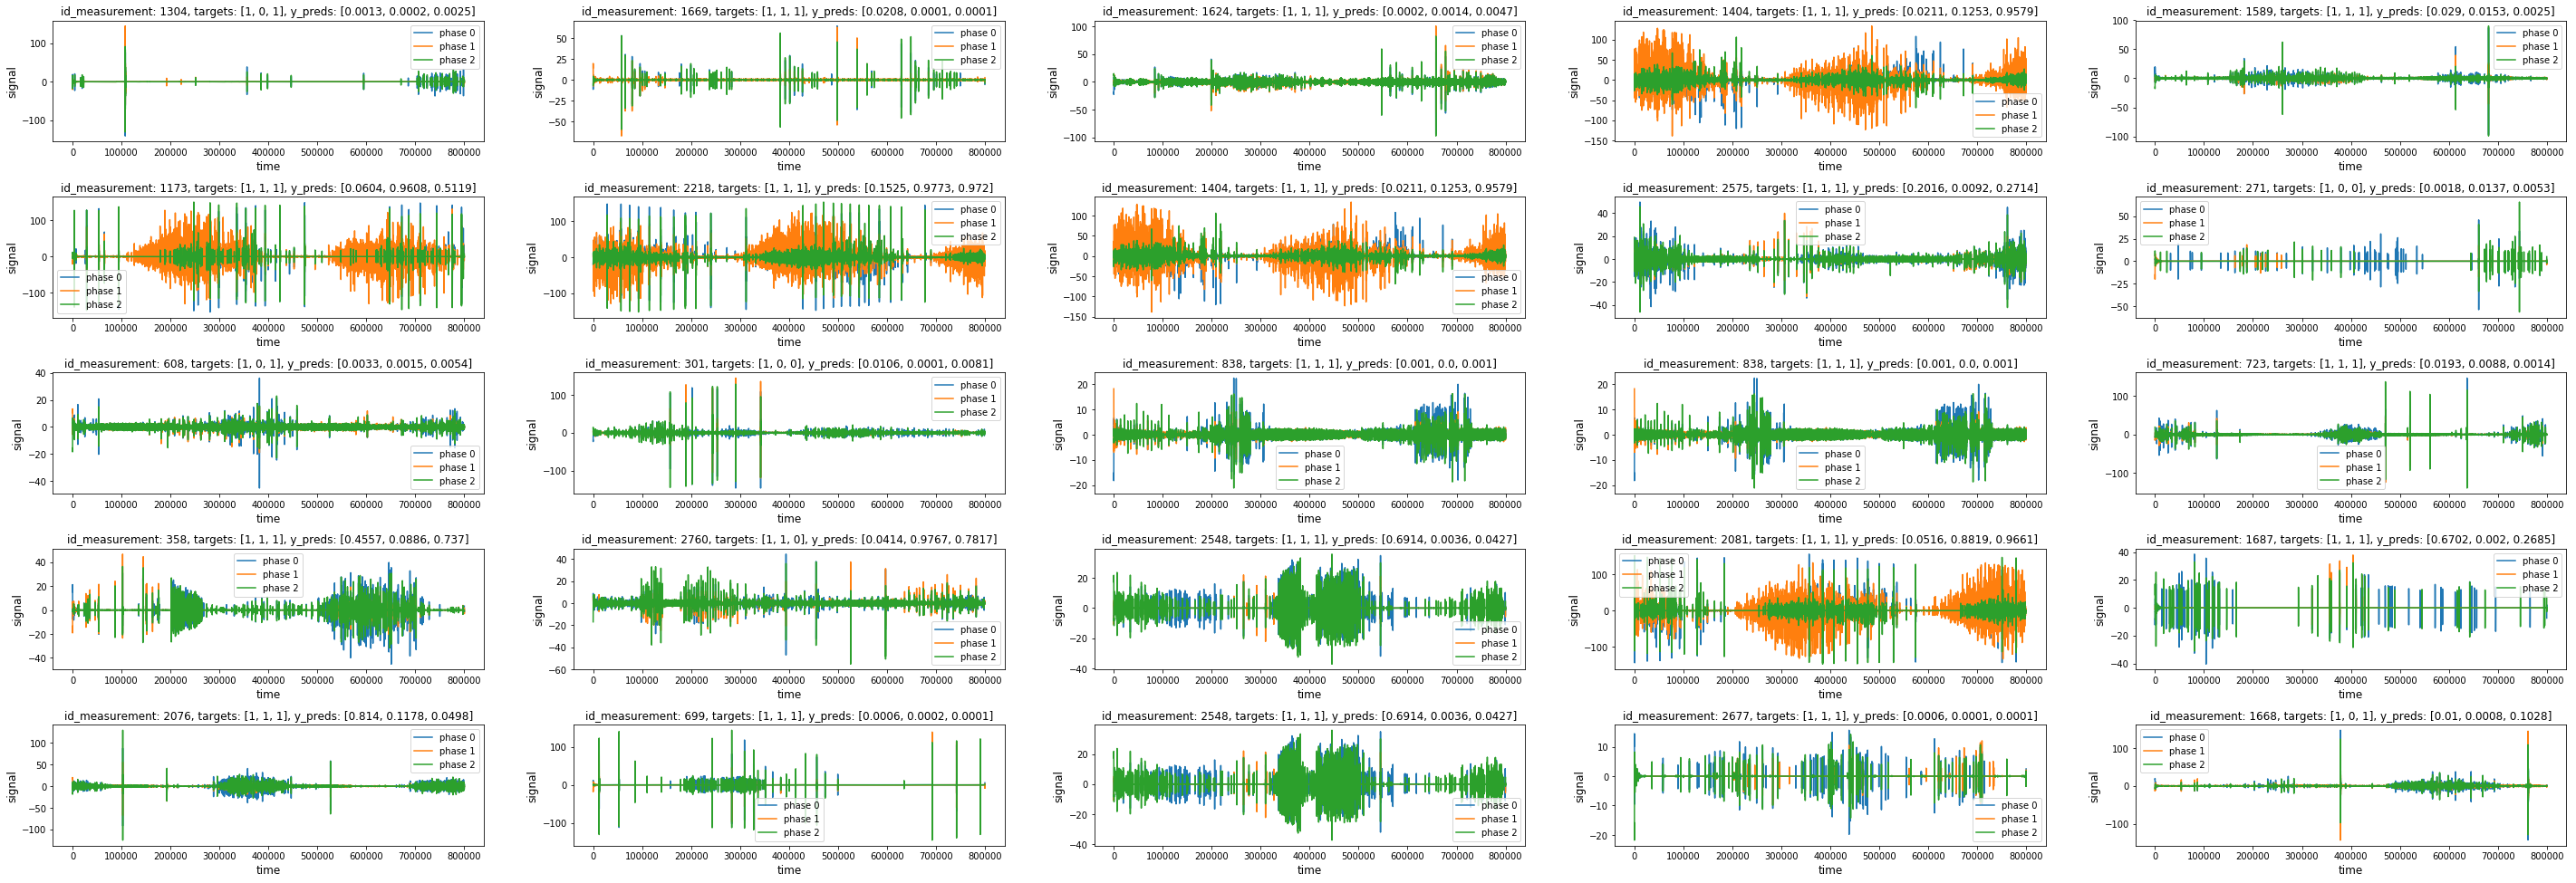

In [11]:
target_df = trn_meta_df.query('target != pred_target').query('target == 1')
targets = target_df.sample(25, random_state=71)
target_ids = targets.id_measurement
plt_3phase_currents(trn_hp_dn_df, trn_meta_df, target_ids, col_num=5)

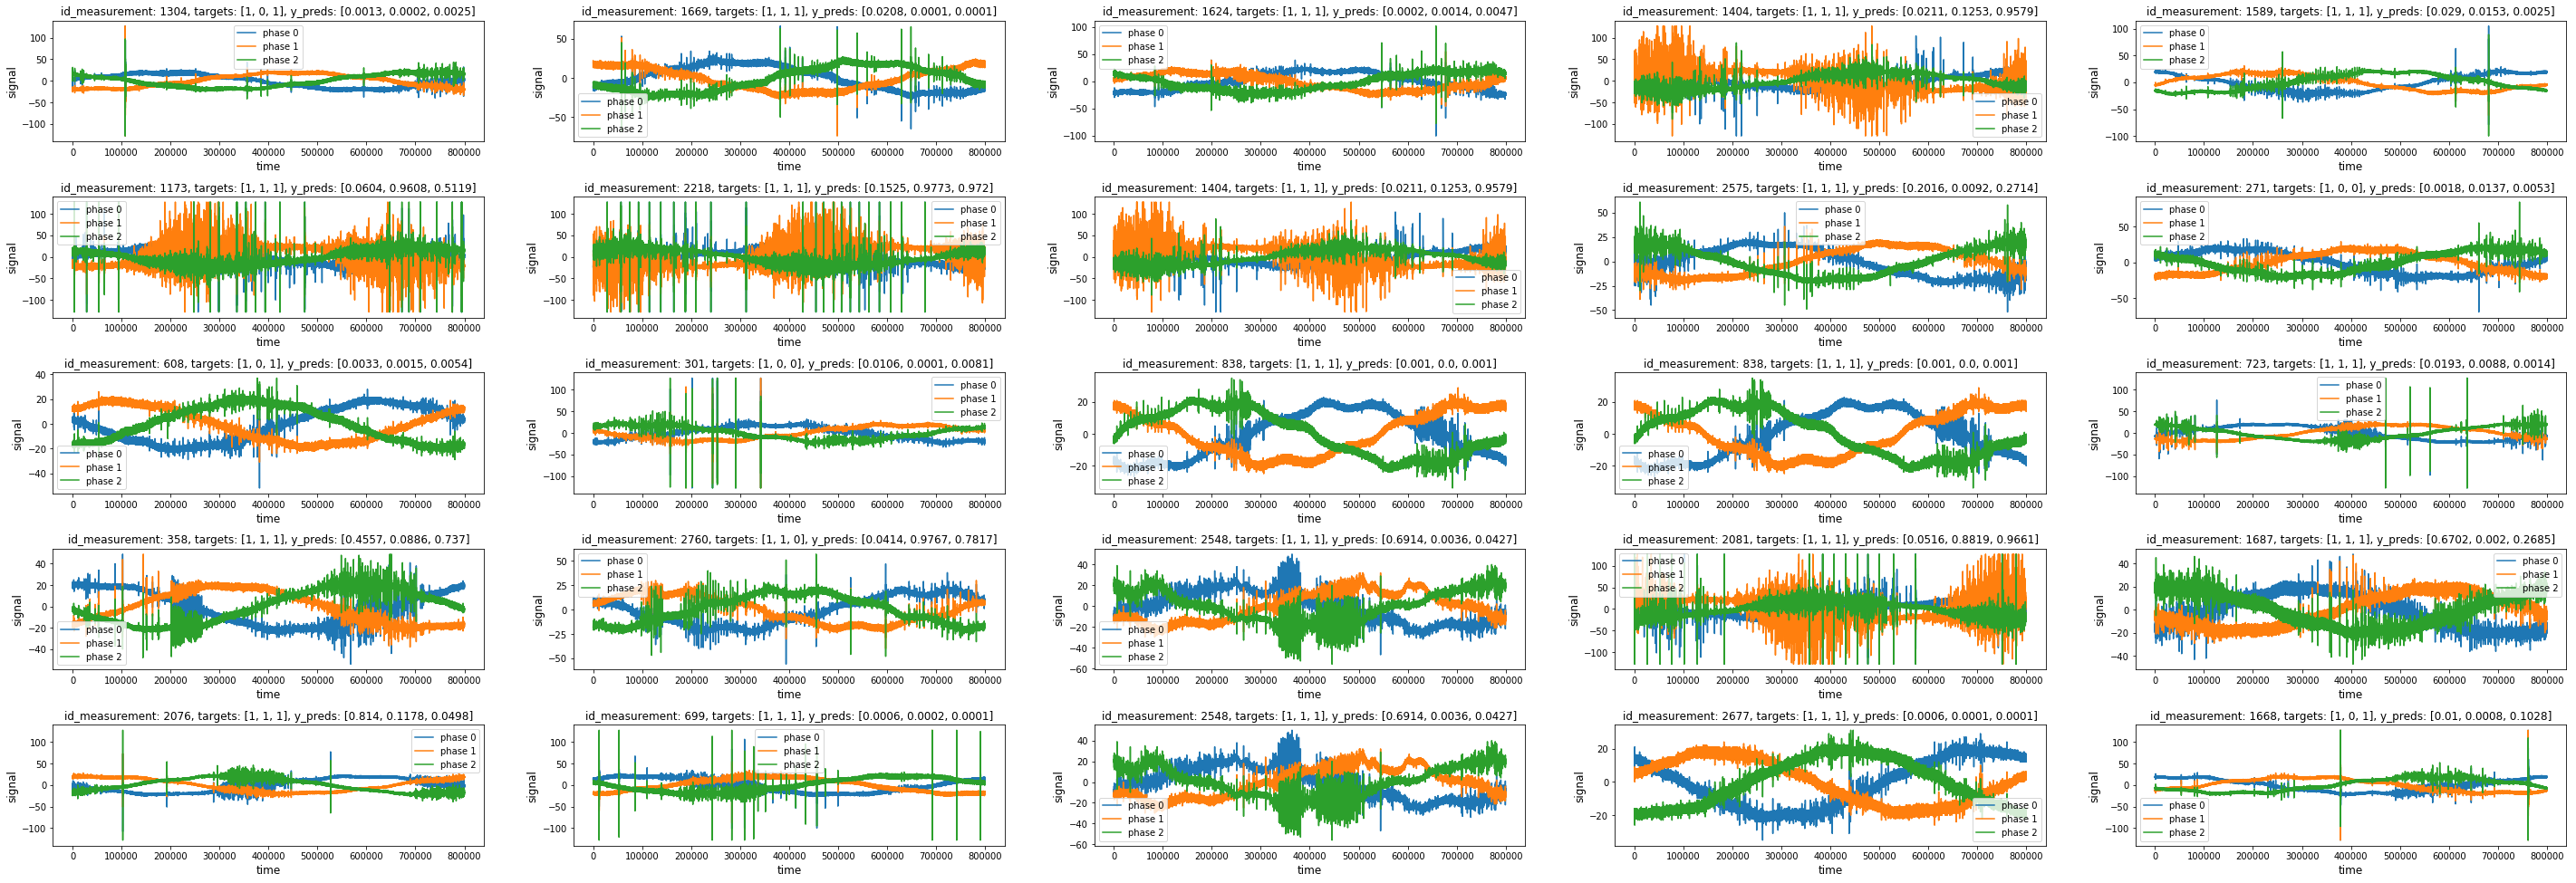

In [12]:
target_df = trn_meta_df.query('target != pred_target').query('target == 1')
targets = target_df.sample(25, random_state=71)
target_ids = targets.id_measurement
plt_3phase_currents(trn_df, trn_meta_df, target_ids, col_num=5)

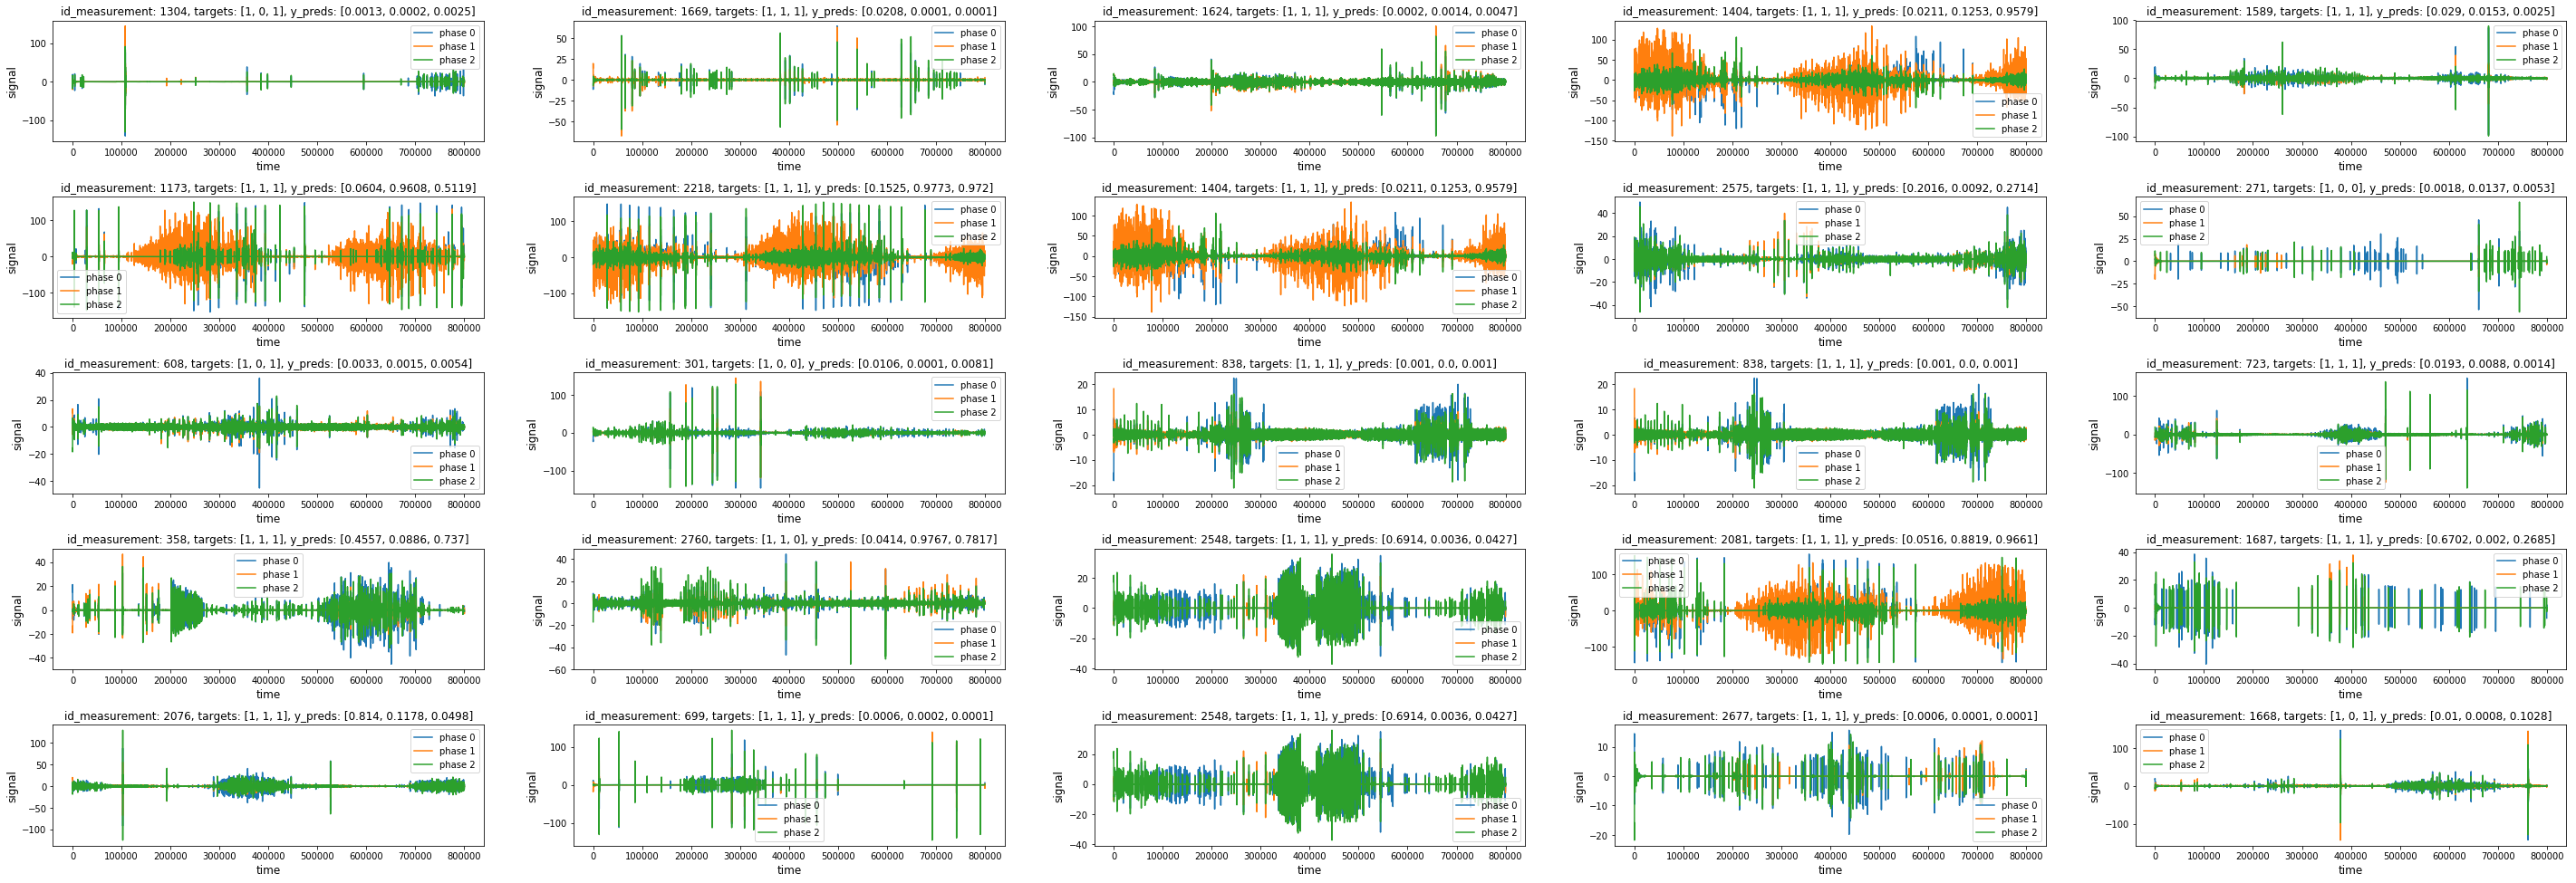

In [14]:
target_df = trn_meta_df.query('target != pred_target').query('target == 1')
targets = target_df.sample(25, random_state=71)
target_ids = targets.id_measurement
plt_3phase_currents(trn_hp_dn_df, trn_meta_df, target_ids, col_num=5)

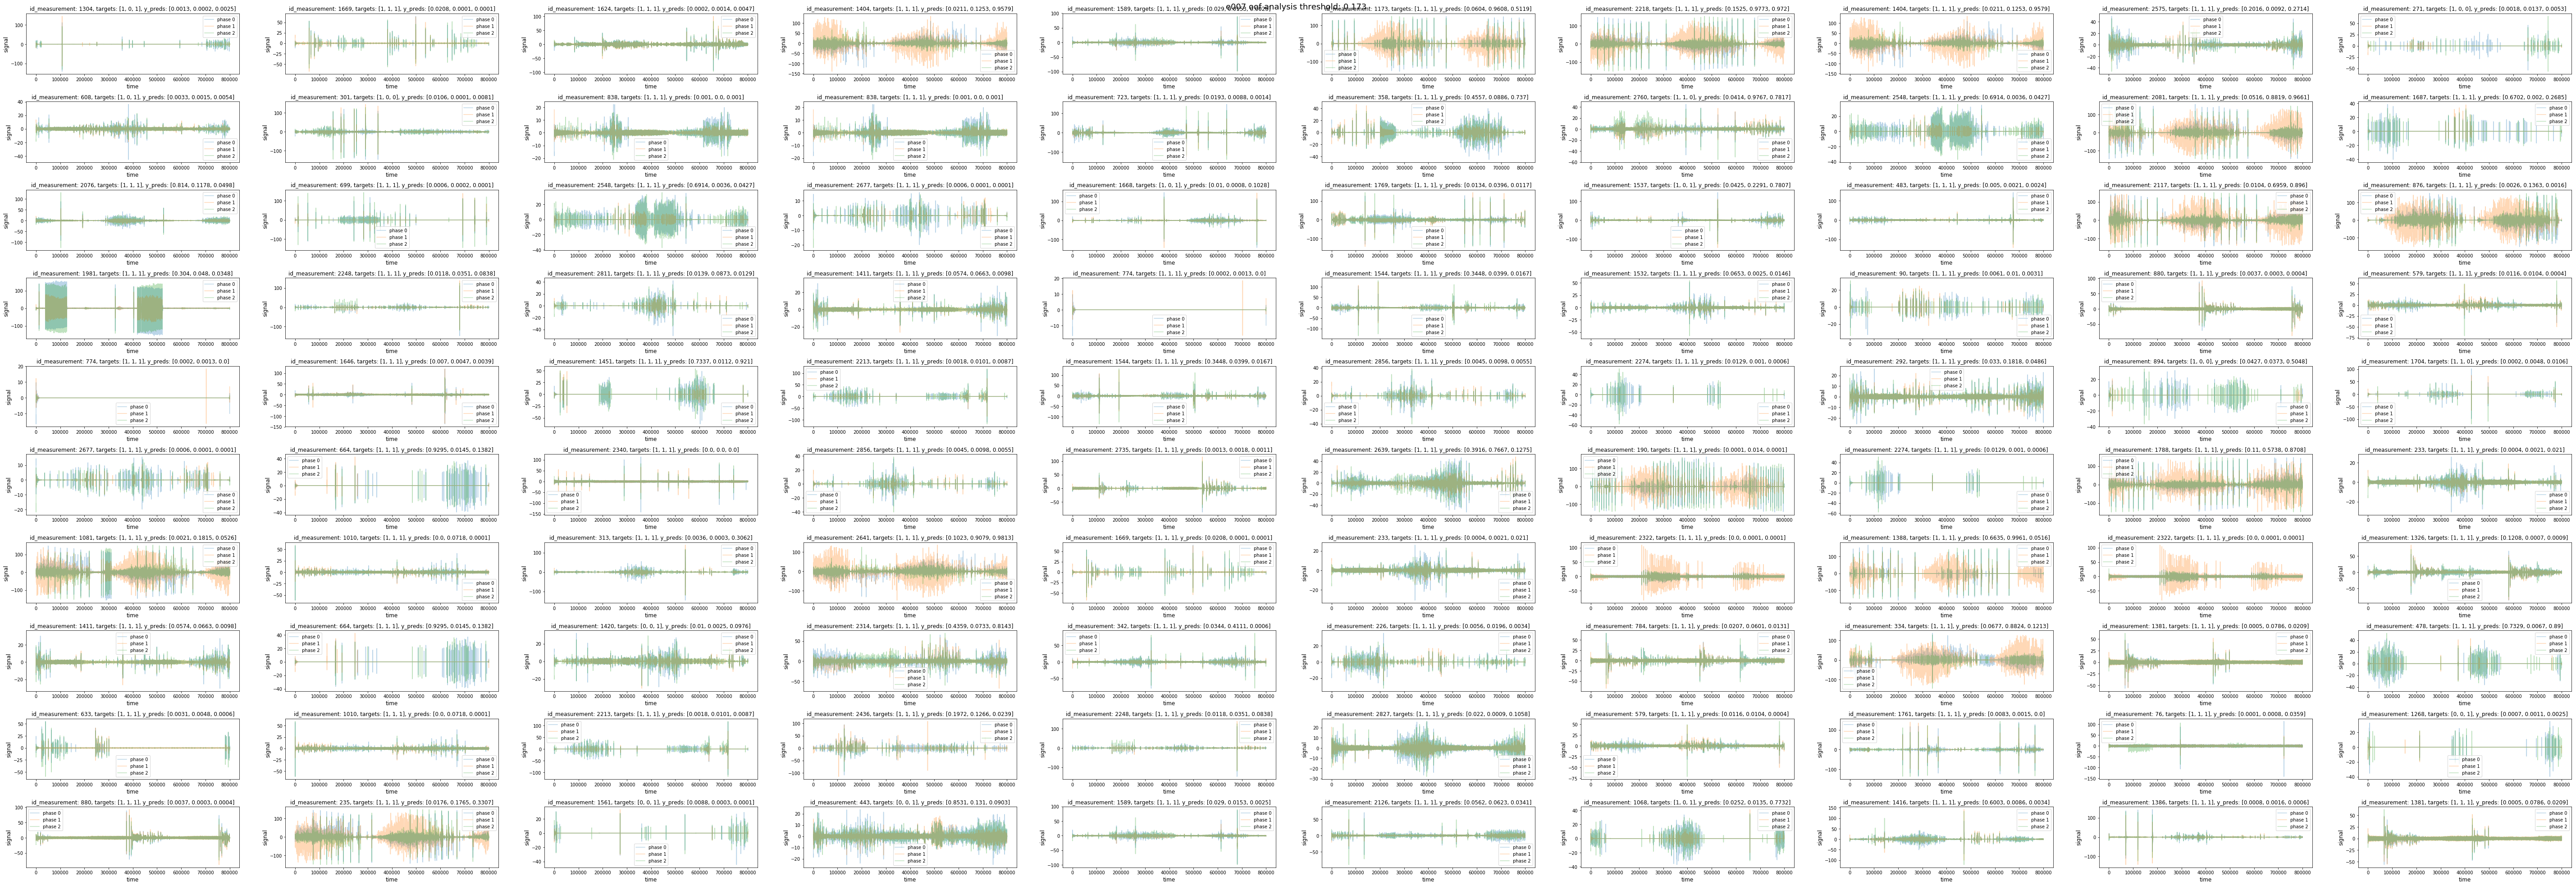

In [24]:
target_df = trn_meta_df.query('target != pred_target').query('target == 1')
targets = target_df.sample(100, random_state=71)
target_ids = targets.id_measurement
plt_3phase_currents(trn_hp_dn_df, trn_meta_df, target_ids, col_num=10, alpha=0.3, fig_title='e007 oof analysis threshold: 0.173')

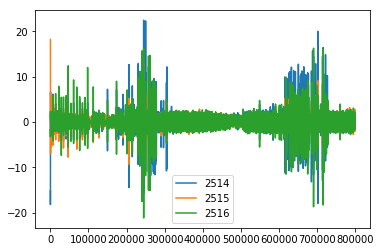

In [28]:
trn_hp_dn_df.iloc[:, 838*3:839*3].plot()

In [30]:
trn_hp_dn_df.iloc[:, 838*3:839*3].astype('float64').std(axis=0)

2514    0.392175
2515    0.383145
2516    0.340641
dtype: float64

In [31]:
trn_hp_dn_df.iloc[:, 723*3:724*3].astype('float64').std(axis=0)

2169    0.715626
2170    0.556318
2171    0.821928
dtype: float64

In [33]:
df = trn_hp_dn_df.iloc[:, 838*3:839*3].astype('float64')
(df/df.max(axis=0)).std(axis=0)

2514    0.017503
2515    0.021085
2516    0.020962
dtype: float64

In [32]:
df = trn_hp_dn_df.iloc[:, 723*3:724*3].astype('float64')
(df/df.max(axis=0)).std(axis=0)

2169    0.004868
2170    0.007720
2171    0.005983
dtype: float64

In [58]:
np.diff([12, 1, 2, 3, 5])

array([-11,   1,   1,   2])

In [57]:
_df = df[df > 4]
a = [np.diff(_df[col].dropna().index) for col in _df.columns]
np.std(a[0]), np.std(a[1]), np.std(a[2]), 

(880.2323407506889, 1939.9980549190864, 1240.8137875514446)

In [35]:
df = trn_hp_dn_df.iloc[:, 1981*3:1982*3].astype('float64')
(df).std(axis=0)

5943    7.187222
5944    2.372746
5945    6.011416
dtype: float64

In [34]:
df = trn_hp_dn_df.iloc[:, 1981*3:1982*3].astype('float64')
(df/df.max(axis=0)).std(axis=0)

5943    0.045633
5944    0.024878
5945    0.042409
dtype: float64